<a href="https://colab.research.google.com/github/PoojaGoel-IIT/deep_learning_assignments/blob/main/NLP_Architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Assignment](https://docs.google.com/document/d/1015q7TN43By8ma-2uWH7A3R_NW8JHILLyvOovMWgjeo/edit?usp=sharing)

In [ ]:
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


Question-1 1A. Download the dataset from the link. We will use the first seven chapters as the training set, next three as validation, and the last two chapters for the test set. Use the sentence and word tokenizer (en_core_web_sm model from SpaCY or NLTK sent_tokenize and word_tokenize). We will append <sos> and <eos> tokens to the beginning and end of the sentence. Report the sizes of the train, val, and test dataset in terms of sequences generated, i.e., the count of sequences.					      
[2 Marks]


In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
import urllib.request
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# Download the file from the URL
url = 'https://www.gutenberg.org/files/1661/1661-0.txt'
urllib.request.urlretrieve(url, 'sherlock.txt')
import re
# Read the text file
with open('sherlock.txt', 'r', encoding='utf-8') as f:
    text = f.read()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [ ]:

chapter_headings = ['I. A SCANDAL IN BOHEMIA','II. THE RED-HEADED LEAGUE','III. A Case of Identity',   'IV. The Boscombe Valley Mystery',
                    'V. The Five Orange Pips',  'VI. The Man with the Twisted Lip',  'VII. The Adventure of the Blue Carbuncle',
                    'VIII. The Adventure of the Speckled Band',    'IX. The Adventure of the Engineer’s Thumb',
                    'X. The Adventure of the Noble Bachelor',    'XI. The Adventure of the Beryl Coronet',    'XII. The Adventure of the Copper Beeches','* END OF THE PROJECT GUTENBERG EBOOK THE ADVENTURES OF SHERLOCK HOLMES *']
chapters = [[] for _ in range(len(chapter_headings))]

chapter_headings = [heading.upper() for heading in chapter_headings]
print(chapter_headings)

# Split the text into chapters
chapters = [[] for _ in range(len(chapter_headings))]
current_chapter = -1
for line in text.split('\n'):
    if line in chapter_headings:
        current_chapter += 1
    if current_chapter >= 0:
        chapters[current_chapter].append(line)

# Store the contents of all chapters in a list
cht_with_text = []
for cht in chapters:
    cht_with_text.append('\n'.join(cht))
print("len of chapters_with_text:",len(cht_with_text))
# print("printing text of chapter last")
# print(chapters_with_text[-2])


['I. A SCANDAL IN BOHEMIA', 'II. THE RED-HEADED LEAGUE', 'III. A CASE OF IDENTITY', 'IV. THE BOSCOMBE VALLEY MYSTERY', 'V. THE FIVE ORANGE PIPS', 'VI. THE MAN WITH THE TWISTED LIP', 'VII. THE ADVENTURE OF THE BLUE CARBUNCLE', 'VIII. THE ADVENTURE OF THE SPECKLED BAND', 'IX. THE ADVENTURE OF THE ENGINEER’S THUMB', 'X. THE ADVENTURE OF THE NOBLE BACHELOR', 'XI. THE ADVENTURE OF THE BERYL CORONET', 'XII. THE ADVENTURE OF THE COPPER BEECHES', '* END OF THE PROJECT GUTENBERG EBOOK THE ADVENTURES OF SHERLOCK HOLMES *']
len of chapters_with_text: 13


In [ ]:
# Extract the chapters_with_text for each set
train_chapters = cht_with_text[0:7]
val_chapters = cht_with_text[7:10]
test_chapters = cht_with_text[10:]

# Preprocess the text and add <sos> and <eos> tokens
def preprocess(text,counter):
    sentences = sent_tokenize(text)
    processed = []
    for sentence in sentences:
        words = ['<sos>'] + word_tokenize(sentence.lower()) + ['<eos>']
        counter+=1
        processed.append(words)
    return processed,counter

# Preprocess the chapters_with_text for each set
train_data = []
t_counter=0
v_counter=0
test_counter=0

# Report the sizes of the train, val, and test datasets

for cht in train_chapters:
    l,t_counter=preprocess(cht,t_counter)
    train_data.extend(l)

val_data = []
for cht in val_chapters:
    l,v_counter=preprocess(cht,v_counter)
    val_data.extend(l)

test_data = []
for cht in test_chapters:
    l,test_counter=preprocess(cht,test_counter)
    test_data.extend(l)

# Report the sizes of the train, val, and test datasets
print(f"Train set size: {len(train_data)} sequences and counter",t_counter)
print(f"Val set size: {len(val_data)} sequences and counter",v_counter)
print(f"Test set size: {len(test_data)} sequences and counter",test_counter)

Train set size: 2689 sequences and counter 2689
Val set size: 1112 sequences and counter 1112
Test set size: 1027 sequences and counter 1027


Question-1.b Train a many-to-many RNN architecture using pytorch that given a sentence si, generates the next sentence si+1, word-by-word. Use the validation set to find best parameters such as number of layers and hidden dimensions. Train the model till it converges and report the train, val and test loss and perplexity (either torch.exp(torch.nn.functional.cross_entropy) or torcheval.metrics.Perplexity) at each epoch.
Marks will be awarded for correct architecture, plots, and the training setup. 		[2 +3+1 Marks]


In [ ]:
import os
import string

import time, random, math, string
from torchtext.legacy import data
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

from torchtext.legacy.data import Field, Dataset, Example
from torchtext.legacy.datasets import LanguageModelingDataset

In [ ]:
tokenizer = lambda x:word_tokenize(x.lower())
reverse_tokenizer = lambda x: tokenizer(x)[::-1]

SRC = data.Field(tokenize=reverse_tokenizer, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = data.Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>', lower=True)



train_examples = []
val_examples = []
test_examples = []

# Step 3: Create examples for training set
for text in train_chapters:
    sentences = sent_tokenize(text)
    for i in range(len(sentences)-1):
        src = sentences[i]
        trg = sentences[i+1]
        train_examples.append(data.Example.fromlist([src, trg], fields=[('src', SRC), ('trg', TRG)]))

# Step 3: Create examples for validation set
for text in val_chapters:
    sentences = sent_tokenize(text)
    for i in range(len(sentences)-1):
        src = sentences[i]
        trg = sentences[i+1]
        val_examples.append(data.Example.fromlist([src, trg], fields=[('src', SRC), ('trg', TRG)]))

# Step 3: Create examples for test set
for text in test_chapters:
    sentences = sent_tokenize(text)
    for i in range(len(sentences)-1):
        src = sentences[i]
        trg = sentences[i+1]
        test_examples.append(data.Example.fromlist([src, trg], fields=[('src', SRC), ('trg', TRG)]))
# Step 6: Create datasets
train_data = Dataset(train_examples, fields=[('src', SRC), ('trg', TRG)])
valid_data = Dataset(val_examples, fields=[('src', SRC), ('trg', TRG)])
test_data = Dataset(test_examples, fields=[('src', SRC), ('trg', TRG)])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of test examples: {len(test_data.examples)}")

Number of training examples: 2682
Number of validation examples: 1109
Number of test examples: 1025


In [ ]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 3133
Unique tokens in target (en) vocabulary: 3137


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATHC_SIZE = 256
# We use a BucketIterator instead of the standard Iterator as it create batches in such a way that it minimizes the amount
# of padding in both the source and target sentences.
train_iter, valid_iter, test_iter = BucketIterator.splits((train_data, valid_data, test_data),
                                                          batch_size=BATHC_SIZE,sort_within_batch=True,
                                                        sort_key=lambda x: len(x.src), device=device)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.RNN(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self,src):
        # src : [sen_len, batch_size]
        embedded = self.dropout(self.embedding(src))
        # embedded : [sen_len, batch_size, emb_dim]
        outputs, hidden = self.rnn(embedded)
        # outputs = [sen_len, batch_size, hid_dim * n_directions]
        # hidden = [n_layers * n_direction, batch_size, hid_dim]
        return hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.RNN(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):

        # one word from all sequences in batches
        input = input.unsqueeze(0)
        #input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        output, hidden = self.rnn(embedded, hidden)
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        prediction = self.fc_out(output.squeeze(0))
        #prediction = [batch size, output dim]
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #trg = [trg len, batch size]

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden = self.encoder(src)

        #first input to the decoder is the <sos> tokens
        input = trg[0,:]

        for t in range(1, trg_len):

            #insert input token embedding, previous hidden states
            #receive output tensor (predictions) and new hidden states
            output, hidden = self.decoder(input, hidden)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from our predictions
            top1 = output.argmax(1)

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs


In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 4
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(encoder, decoder, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3133, 256)
    (rnn): RNN(256, 512, num_layers=4, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3137, 256)
    (rnn): RNN(256, 512, num_layers=4, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=3137, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,154,753 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip, summaryWriter=None):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # trg = [sen_len, batch_size]
        # output = [trg_len, batch_size, output_dim]
        output = model(src, trg)
        output_dim = model.decoder.output_dim

        # transfrom our output : slice off the first column, and flatten the output into 2 dim.
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        # trg = [(trg_len-1) * batch_size]
        # output = [(trg_len-1) * batch_size, output_dim]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()
        if summaryWriter:
          train_step += 1
          summaryWriter.add_scalar('training loss vs step', loss, train_step)

    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, summaryWriter=None):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # Turn off teacher forcing
            output = model(src, trg, 0)

            # Flatten output and target
            output_dim = model.decoder.output_dim
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            # Compute loss
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            if summaryWriter:
              valid_step += 1
              summaryWriter.add_scalar('validation loss vs step', loss, valid_step)

    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time  / 60)
    elapsed_secs = int(elapsed_time -  (elapsed_mins * 60))
    return  elapsed_mins, elapsed_secs

Epoch: 01 | Time 0m 12s
	Train Loss: 6.570 | Train PPL: 713.426
	Valid Loss: 5.441 | Valid PPL: 230.626
Epoch: 02 | Time 0m 12s
	Train Loss: 6.216 | Train PPL: 500.500
	Valid Loss: 5.424 | Valid PPL: 226.873
Epoch: 03 | Time 0m 12s
	Train Loss: 5.653 | Train PPL: 285.282
	Valid Loss: 5.393 | Valid PPL: 219.792
Epoch: 04 | Time 0m 12s
	Train Loss: 5.617 | Train PPL: 275.036
	Valid Loss: 5.376 | Valid PPL: 216.210
Epoch: 05 | Time 0m 12s
	Train Loss: 5.614 | Train PPL: 274.217
	Valid Loss: 5.366 | Valid PPL: 213.997
Epoch: 06 | Time 0m 12s
	Train Loss: 5.611 | Train PPL: 273.372
	Valid Loss: 5.370 | Valid PPL: 214.870
Epoch: 07 | Time 0m 12s
	Train Loss: 5.584 | Train PPL: 266.249
	Valid Loss: 5.362 | Valid PPL: 213.078
Epoch: 08 | Time 0m 12s
	Train Loss: 5.586 | Train PPL: 266.593
	Valid Loss: 5.362 | Valid PPL: 213.234
Epoch: 09 | Time 0m 12s
	Train Loss: 5.574 | Train PPL: 263.456
	Valid Loss: 5.349 | Valid PPL: 210.420
Epoch: 10 | Time 0m 12s
	Train Loss: 5.571 | Train PPL: 262.634


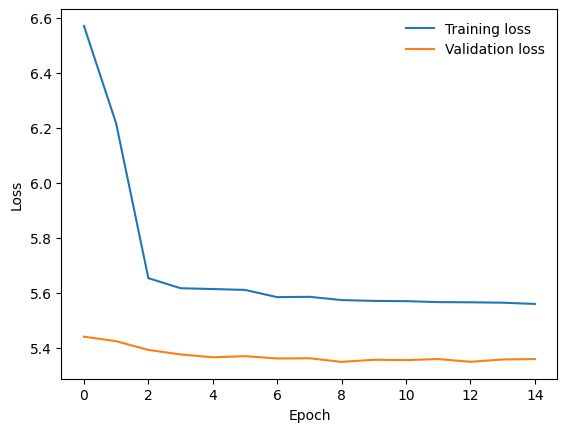

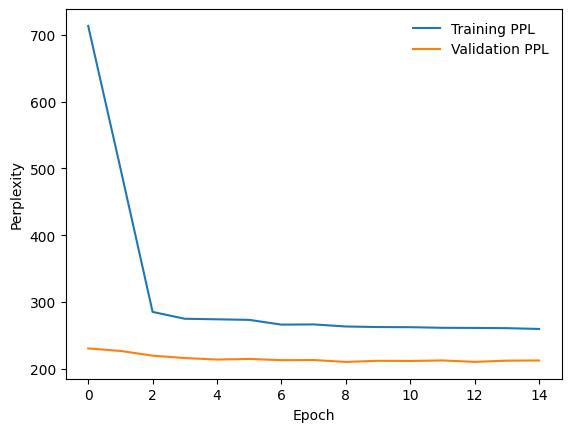

In [ ]:
import time
import math
import torch
import matplotlib.pyplot as plt

N_EPOCHS = 15
CLIP = 1
best_valid_loss = float('inf')
train_losses = []
train_ppls = []
valid_losses = []
valid_ppls = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_iter, optimizer, criterion, CLIP, summaryWriter=None)
    valid_loss = evaluate(model, valid_iter, criterion, summaryWriter=None)
    train_ppl = math.exp(train_loss)
    valid_ppl = math.exp(valid_loss)
    train_losses.append(train_loss)
    train_ppls.append(train_ppl)
    valid_losses.append(valid_loss)
    valid_ppls.append(valid_ppl)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'Seq2SeqModel.pt')
    print(f"Epoch: {epoch+1:02} | Time {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:.3f}")
    print(f"\tValid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:.3f}")

# Plot the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the training and validation perplexity
plt.plot(train_ppls, label='Training PPL')
plt.plot(valid_ppls, label='Validation PPL')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.show()


In [ ]:
def test():
    best_model = Seq2Seq(encoder, decoder, device).to(device)
    best_model.load_state_dict(torch.load('Seq2SeqModel.pt'))

    test_loss = evaluate(model, test_iter, criterion)

    print(f"loss in test : {test_loss:.3f} | Test Perplexity: {math.exp(test_loss):7.3f}")

test()

loss in test : 5.108 | Test Perplexity: 165.270


Question-2 Suppose we want to build a LSTM classifier (LSTM + Linear) that, given an input sentence in the stories in the dataset, predicts the story id the input sentence belongs to. As can be observed from the dataset, there are twelve stories. Explain how the training, validation and test set be created. What will be the inputs to the model and outputs? Explain what components will be used in the architecture with a diagram and report relevant dimension sizes of the input and output of each component. What loss function should be used in this task? Use the conventions in the pytorch documentation, L = max_seq_length, N = batch size, D=1, H_in = input_size, H_cell = hidden size, H_out = proj_size.  	      
[2 Marks]


**Answer:**  
we need to preprocess the data before feeding to model.

**Dataset Split and tokenization**:

We do sentence and word tokenization
Dataset will be X,Y where xi is ith sentences and yi is true label of the corresponding sentence.
yi belongs to {1-12)
we shuffle and split the dataset into train, test and validation set. Ratio 60:20:20.

**Input and Output:**

Inputs to the LSTM classifier: Sentences from the stories in the dataset
Outputs from the LSTM classifier: Predicted story ID for each input sentence


**LSTM + LINEAR Architecture:**

            +-----------------------------------+

            |           Input Sentence          |
            |                (N,L)              |
            +------------------+----------------+
                               |
            +------------------v----------------+
            |            Word Embedding         |
            |           (N,L) ->(N,L,H_in)      |
            +-------------------+---------------+
                                |
            +-------------------v---------------+
            |                 LSTM              |
            |         (N,L,H_in)->(N,L,h_cell)  |
            +-------------------+---------------+
                                |
            +--------------------v--------------+
            |      Projection layer dimensions  |
            |       (L,N,H_Cell)->(L,N,H_out)   |
            +-------------------+---------------+
                                |
            +-------------------v---------------+          
            |               Linear Layer        |
            |   (N*L,H_out)->(N*L, num_stories) |
            +------------------+----------------+
                               |
            +-------------------v---------------+
            |          Softmax Activation       |
            |          (N, num_stories)         |
            +------------------+----------------+


Input (N,L)
Embedding layer : converts words in to word embedding
(N,L)  -> (N,L,H_in)

LSTM layer dimensions:
(N,L,H_in) -> (N,L,H_cell)

Projection layer dimensions: to reduce the dimensionality
(L,N,H_cell) -> (L,N,H_out)

Linear layer: flatten output obtained then input to linear layer then applying Softmax activaiton function
(N*L,H_out) -> (N*L, num_stories)

y_out = argmax (probability of each story id)

where num_stories = 12
 L = max_seq_length,
 N = batch size, D=1,
 H_in = input_size,
 H_cell = hidden size,
 H_out = proj_size.

**Loss Function:**

categorical Cross-Entropy Loss: This is a common loss function used for multi-class classification tasks, which calculates the loss between the predicted probabilities and the true labels (story IDs) for each input sentence
